In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-data-2017-2021/merged_17_21.csv


In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess
df = pd.read_csv("/kaggle/input/financial-data-2017-2021/merged_17_21.csv", parse_dates=['date'])
df = df.sort_values('date')

# Feature Engineering
df['open_lag1'] = df['Open'].shift(1)
df['close_lag1'] = df['Close'].shift(1)
df['high_lag1'] = df['High'].shift(1)
df['low_lag1'] = df['Low'].shift(1)
df['volume_lag1'] = df['Volume'].shift(1)
df['rolling_vol'] = df['Close'].rolling(5).std()
df['momentum'] = df['Close'] - df['Close'].shift(5)

df = df.dropna().reset_index(drop=True)

# Columns
input_features = ['sentiment', 'goldstein_mean',
                  'open_lag1', 'close_lag1', 'high_lag1', 'low_lag1',
                  'volume_lag1', 'rolling_vol', 'momentum']
target_features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Split
train_df = df[df['date'] <= '2020-12-31']
test_df = df[df['date'] > '2020-12-31']

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(train_df[input_features])
Y_train = scaler_y.fit_transform(train_df[target_features])
X_test = scaler_x.transform(test_df[input_features])
Y_test = scaler_y.transform(test_df[target_features])


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len=30):
        self.X, self.y = [], []
        for i in range(len(X) - seq_len):
            self.X.append(X[i:i+seq_len])
            self.y.append(y[i+seq_len])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

seq_len = 30
batch_size = 64
train_data = SequenceDataset(X_train, Y_train, seq_len)
test_data = SequenceDataset(X_test, Y_test, seq_len)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [38]:
from torch import nn
from einops import rearrange

class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)
        self.output = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = rearrange(x, 'b s f -> b f s')
        x = self.linear(x)  # (b, f, pred_len)
        x = rearrange(x, 'b f p -> b p f')
        x = self.output(x[:, -1, :])  # Only last prediction
        return x

model = DLinear(seq_len=seq_len, pred_len=1, input_dim=len(input_features), output_dim=5).to(device)


In [39]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")


Epoch 10/100, Loss: 0.019647
Epoch 20/100, Loss: 0.011288
Epoch 30/100, Loss: 0.007562
Epoch 40/100, Loss: 0.005594
Epoch 50/100, Loss: 0.004532
Epoch 60/100, Loss: 0.003955
Epoch 70/100, Loss: 0.003604
Epoch 80/100, Loss: 0.003319
Epoch 90/100, Loss: 0.003079
Epoch 100/100, Loss: 0.002900


In [40]:
from sklearn.metrics import mean_squared_error

model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch).cpu().numpy()
        actual = y_batch.numpy()
        predictions.append(pred[0])
        actuals.append(actual[0])

predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# Compute RMSE
rmses = np.sqrt(np.mean((actuals - predictions)**2, axis=0))
for i, col in enumerate(target_features):
    print(f"RMSE for {col}: {rmses[i]:.4f}")


RMSE for Open: 340.3108
RMSE for High: 571.1730
RMSE for Low: 511.9696
RMSE for Close: 267.1874
RMSE for Volume: 345239.2784


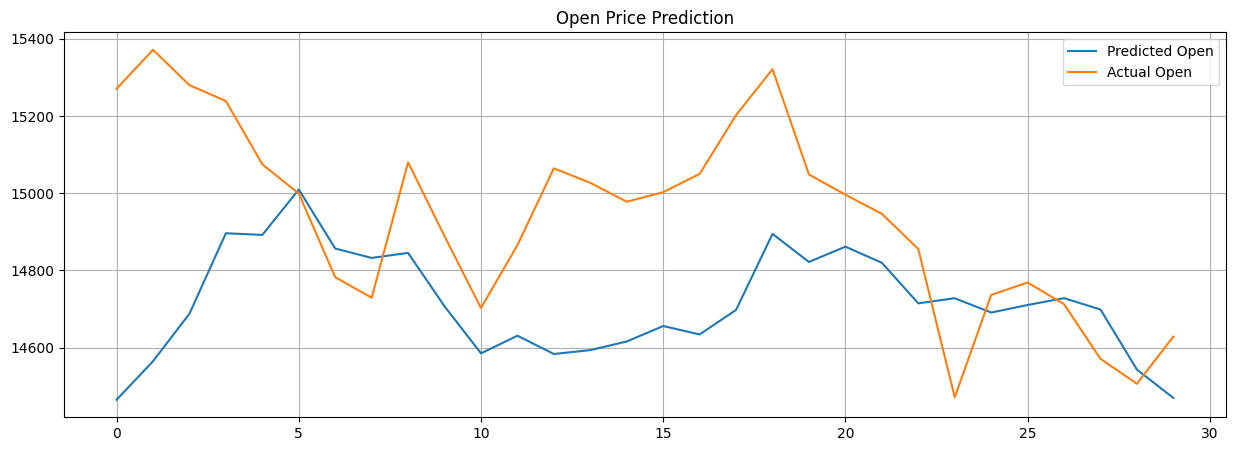

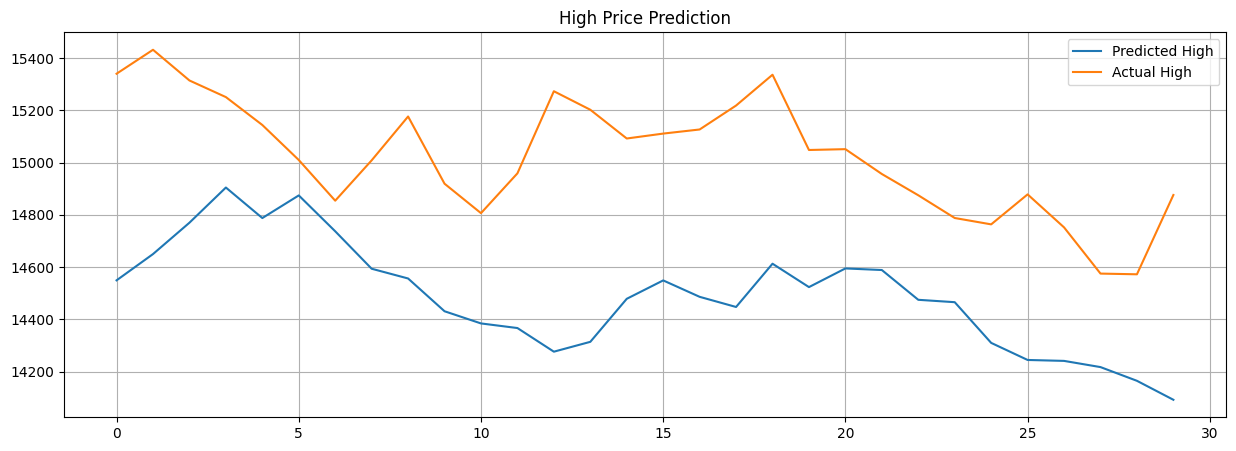

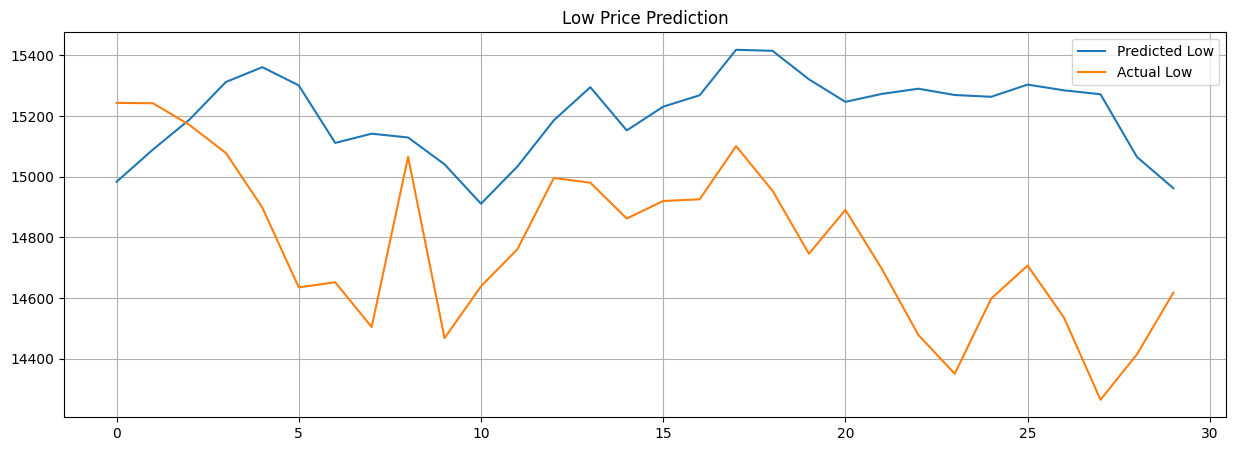

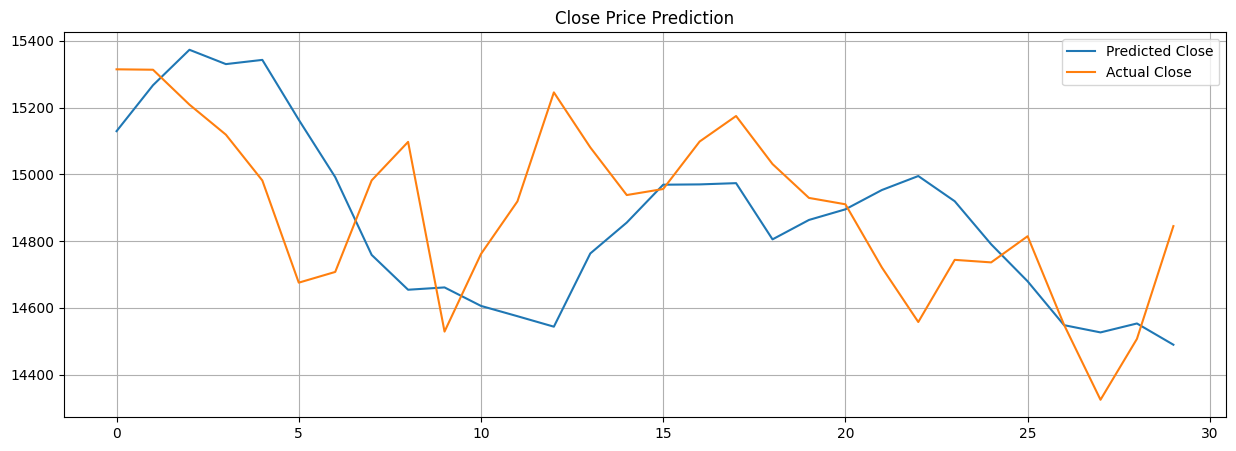

In [41]:
import matplotlib.pyplot as plt

for i, col in enumerate(target_features[:4]):
    plt.figure(figsize=(15, 5))
    plt.plot(predictions[:, i], label=f'Predicted {col}')
    plt.plot(actuals[:, i], label=f'Actual {col}')
    plt.title(f'{col} Price Prediction')
    plt.legend()
    plt.grid()
    plt.show()


yo now the goldstein and sentiment are removed 

/tmp/ipykernel_35/1103414312.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


Epoch 10/100, Loss: 0.122494
Epoch 20/100, Loss: 0.007729
Epoch 30/100, Loss: 0.005597
Epoch 40/100, Loss: 0.004630
Epoch 50/100, Loss: 0.003982
Epoch 60/100, Loss: 0.003575
Epoch 70/100, Loss: 0.003193
Epoch 80/100, Loss: 0.002939
Epoch 90/100, Loss: 0.002669
Epoch 100/100, Loss: 0.002549
RMSE for Open: 456.4317
RMSE for High: 1031.1782
RMSE for Low: 323.0222
RMSE for Close: 300.4169
RMSE for Volume: 309876.3053


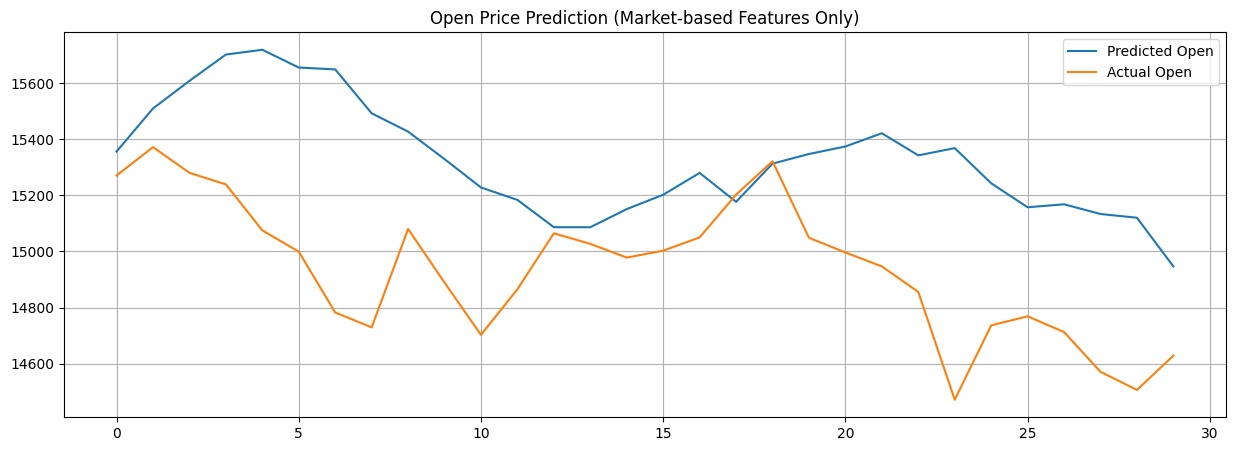

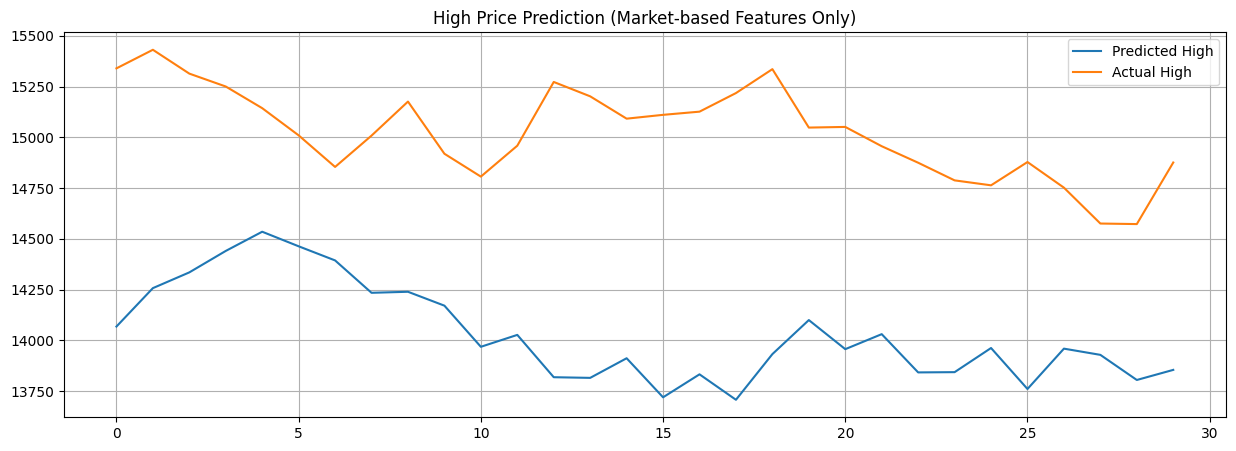

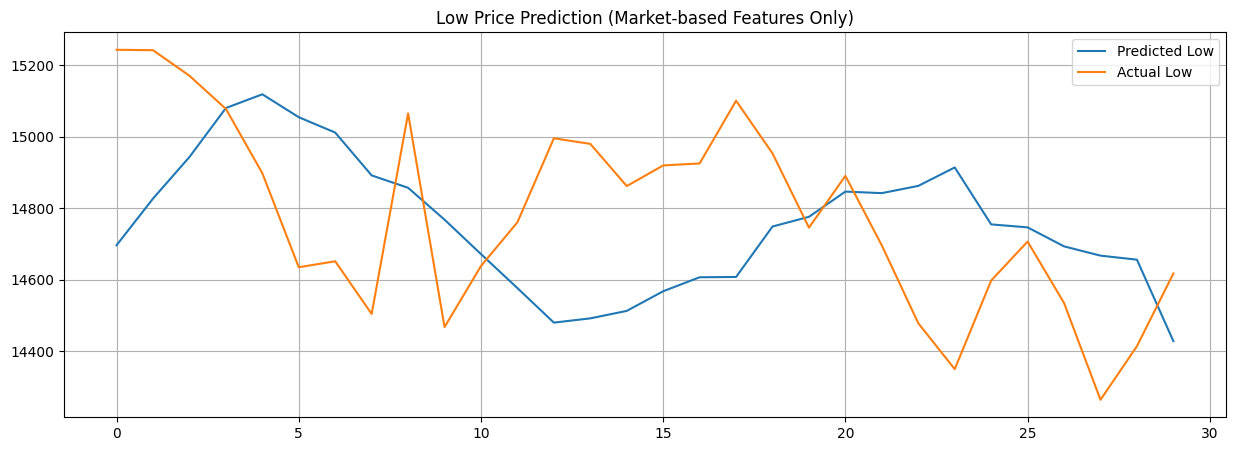

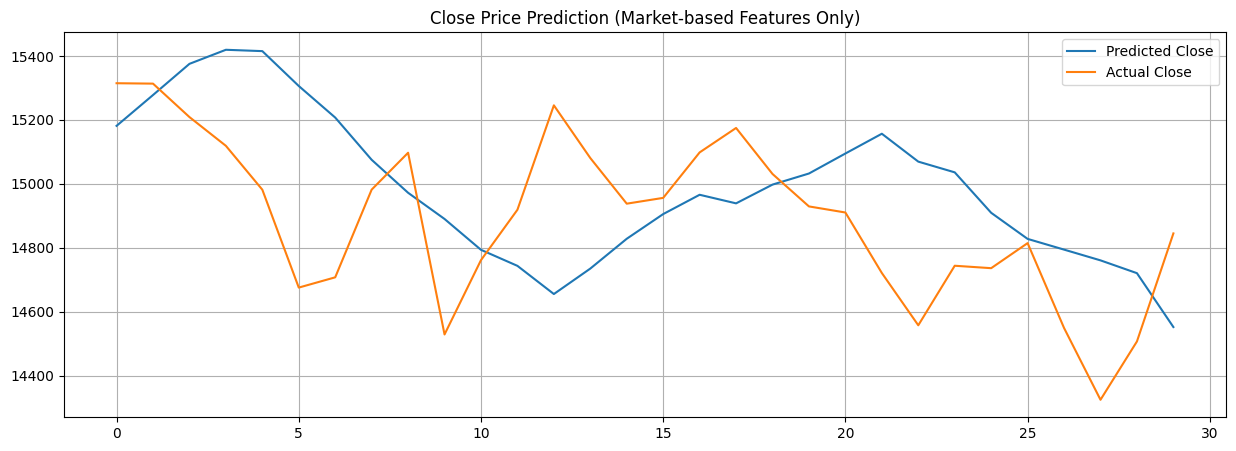

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and preprocess
df = pd.read_csv("/kaggle/input/financial-data-2017-2021/merged_17_21.csv")
df = df.sort_values('date')

# Feature Engineering (market-only inputs)
df['open_lag1'] = df['Open'].shift(1)
df['close_lag1'] = df['Close'].shift(1)
df['high_lag1'] = df['High'].shift(1)
df['low_lag1'] = df['Low'].shift(1)
df['volume_lag1'] = df['Volume'].shift(1)
df['rolling_vol'] = df['Close'].rolling(5).std()
df['momentum'] = df['Close'] - df['Close'].shift(5)

df = df.dropna().reset_index(drop=True)

# Updated input features: exclude sentiment and goldstein
input_features = ['open_lag1', 'close_lag1', 'high_lag1', 'low_lag1',
                  'volume_lag1', 'rolling_vol', 'momentum']
target_features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Split into train and test
train_df = df[df['date'] <= '2020-12-31']
test_df = df[df['date'] > '2020-12-31']

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(train_df[input_features])
Y_train = scaler_y.fit_transform(train_df[target_features])
X_test = scaler_x.transform(test_df[input_features])
Y_test = scaler_y.transform(test_df[target_features])

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len=30):
        self.X, self.y = [], []
        for i in range(len(X) - seq_len):
            self.X.append(X[i:i+seq_len])
            self.y.append(y[i+seq_len])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare loaders
seq_len = 30
batch_size = 64

train_data = SequenceDataset(X_train, Y_train, seq_len)
test_data = SequenceDataset(X_test, Y_test, seq_len)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DLinear Model
class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)
        self.output = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = rearrange(x, 'b s f -> b f s')  # (B, F, S)
        x = self.linear(x)                  # (B, F, pred_len)
        x = rearrange(x, 'b f p -> b p f')  # (B, pred_len, F)
        return self.output(x[:, -1, :])     # (B, output_dim)

# Initialize model
model = DLinear(seq_len=seq_len, pred_len=1, input_dim=len(input_features), output_dim=5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

# Inference and Evaluation
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch).cpu().numpy()
        actual = y_batch.numpy()
        predictions.append(pred[0])
        actuals.append(actual[0])

# Inverse scaling
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# RMSE
rmses = np.sqrt(np.mean((actuals - predictions) ** 2, axis=0))
for i, col in enumerate(target_features):
    print(f"RMSE for {col}: {rmses[i]:.4f}")

# Plotting
for i, col in enumerate(target_features[:4]):
    plt.figure(figsize=(15, 5))
    plt.plot(predictions[:, i], label=f'Predicted {col}')
    plt.plot(actuals[:, i], label=f'Actual {col}')
    plt.title(f'{col} Price Prediction (Market-based Features Only)')
    plt.legend()
    plt.grid()
    plt.show()


new way using lstm and ccm 

Train data size: 977
Test data size: 60


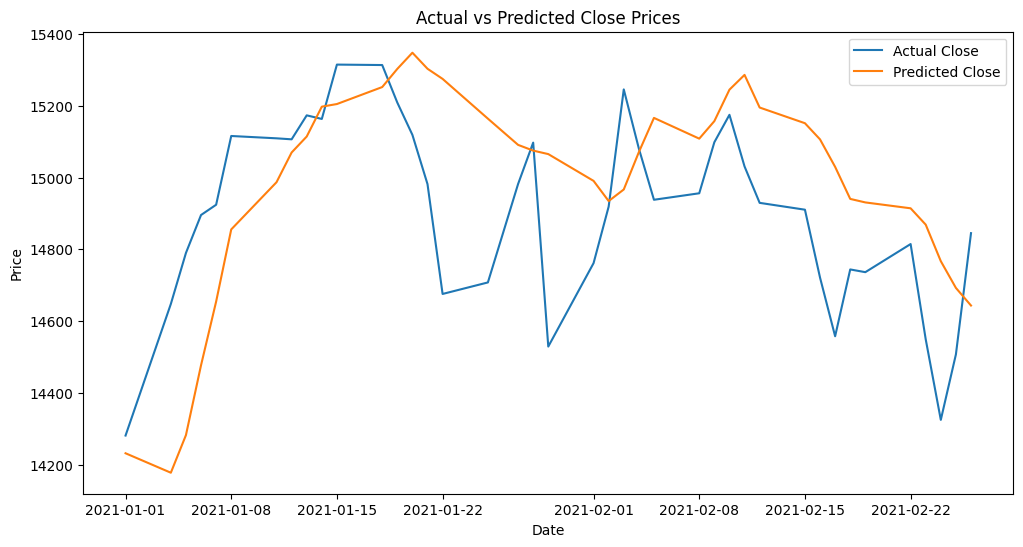

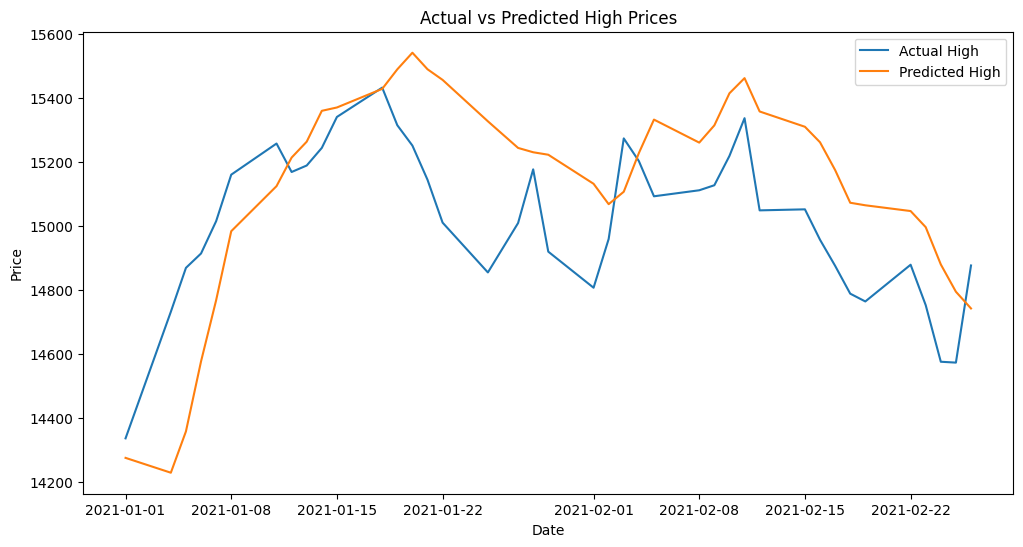

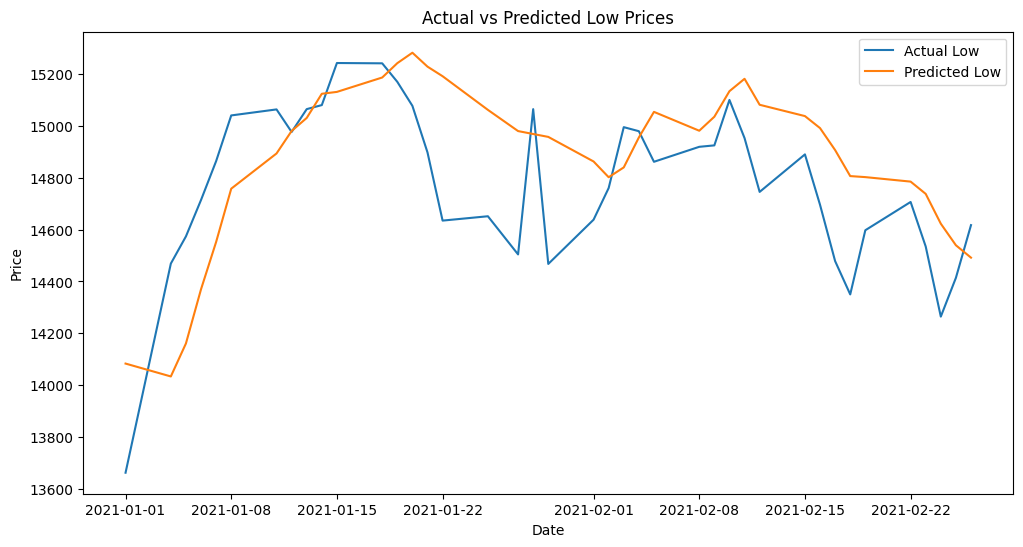

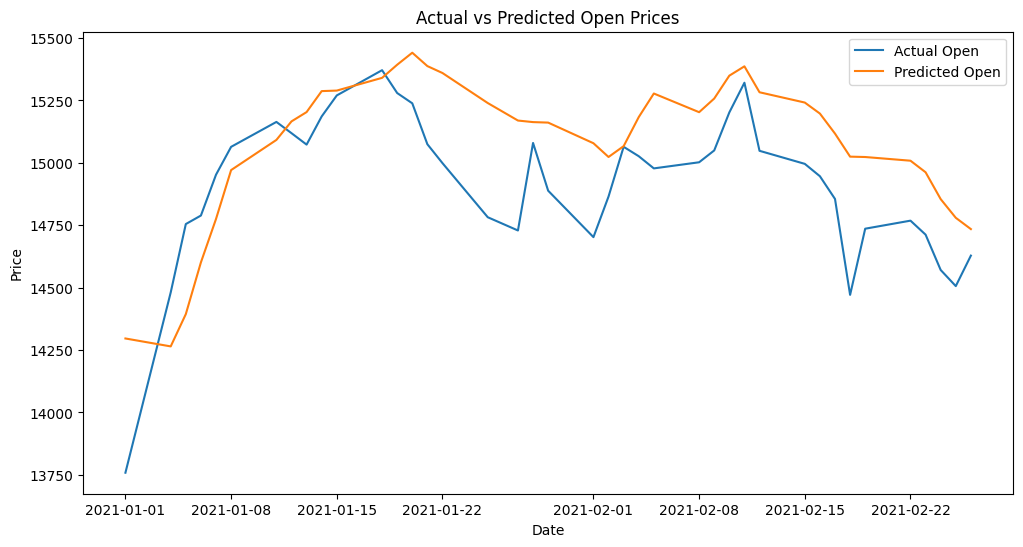

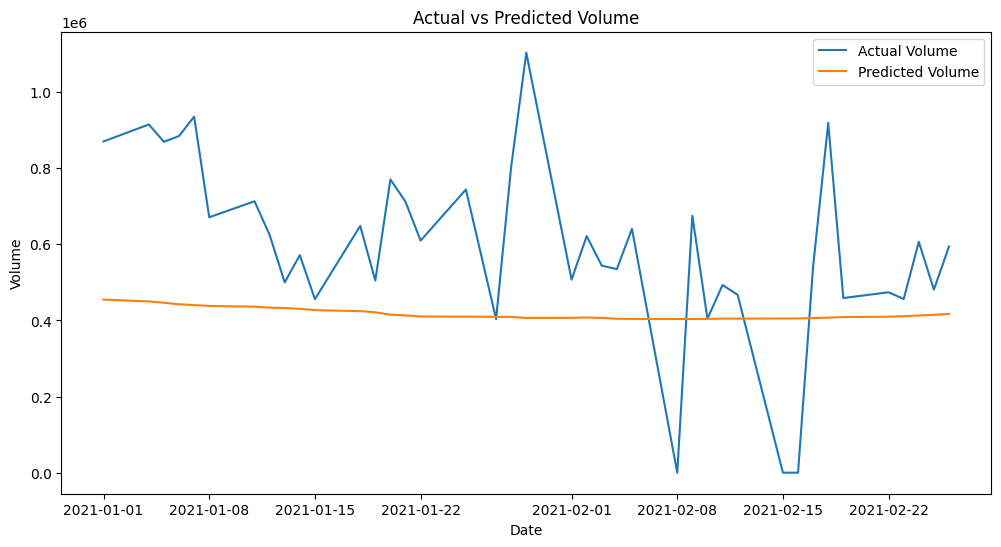

In [13]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = data  # Features (e.g., sentiment and Close)
        self.targets = targets  # All targets (High, Low, Close, Open, Volume)
        self.seq_length = seq_length

    def __len__(self):
        return max(0, len(self.data) - self.seq_length)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.targets[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, num_layers=2, output_size=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load and inspect CSV data
data = pd.read_csv("/kaggle/input/financial-data-2017-2021/merged_17_21.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Prepare features and targets
features = data[['sentiment']].values
targets = data[['High', 'Low', 'Close', 'Open', 'Volume']].values

# Normalize data
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

# Combine features and Close (as initial target) into data_scaled for sequence
data_scaled = np.hstack((features_scaled, targets_scaled[:, [2]]))  # Sentiment + Close

# Split data (2017-2020 train, 2021 test)
train_data = data_scaled[data.index < '2021-01-01']
train_targets = targets_scaled[data.index < '2021-01-01']
test_data = data_scaled[data.index >= '2021-01-01']
test_targets = targets_scaled[data.index >= '2021-01-01']
test_dates = data.index[data.index >= '2021-01-01'][:len(test_data)-20]

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# Create datasets
seq_length = 20
train_dataset = StockDataset(train_data, train_targets, seq_length)
test_dataset = StockDataset(test_data, test_targets, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

if len(test_dataset) == 0:
    raise ValueError("Test dataset is too small for the given sequence length. Reduce seq_length or increase test data.")

# Initialize model
model = LSTMModel(input_size=2, output_size=5).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, optimizer, loader, epochs=50):
    model.train()
    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)  # y now matches output_size=5
            loss.backward()
            optimizer.step()

# Train model
train_model(model, optimizer, train_loader)

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            predictions.append(out.cpu().numpy())
            actuals.append(y.cpu().numpy())
    if not predictions:
        return np.array([]), np.array([])
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    return predictions, actuals

pred, act = evaluate_model(model, test_loader)

if pred.size == 0:
    raise ValueError("No predictions generated. Test dataset may be too small.")

# Inverse transform predictions and actuals
pred_inv = scaler_targets.inverse_transform(pred)
act_inv = scaler_targets.inverse_transform(act)

# Extract predicted and actual values
pred_high, pred_low, pred_close, pred_open, pred_volume = pred_inv.T
act_high, act_low, act_close, act_open, act_volume = act_inv.T

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_close)], act_close, label='Actual Close')
plt.plot(test_dates[:len(pred_close)], pred_close, label='Predicted Close')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_high)], act_high, label='Actual High')
plt.plot(test_dates[:len(pred_high)], pred_high, label='Predicted High')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_low)], act_low, label='Actual Low')
plt.plot(test_dates[:len(pred_low)], pred_low, label='Predicted Low')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_open)], act_open, label='Actual Open')
plt.plot(test_dates[:len(pred_open)], pred_open, label='Predicted Open')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_volume)], act_volume, label='Actual Volume')
plt.plot(test_dates[:len(pred_volume)], pred_volume, label='Predicted Volume')
plt.title('Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

refinement 

Train data size: 977
Test data size: 60
Epoch 1, Loss: 0.057581
Epoch 2, Loss: 0.016724
Epoch 3, Loss: 0.009831
Epoch 4, Loss: 0.007438
Epoch 5, Loss: 0.006861
Epoch 6, Loss: 0.006530
Epoch 7, Loss: 0.005983
Epoch 8, Loss: 0.006059
Epoch 9, Loss: 0.005927
Epoch 10, Loss: 0.005543
Epoch 11, Loss: 0.005439
Epoch 12, Loss: 0.005406
Epoch 13, Loss: 0.005487
Epoch 14, Loss: 0.005257
Epoch 15, Loss: 0.005174
Epoch 16, Loss: 0.004992
Epoch 17, Loss: 0.005121
Epoch 18, Loss: 0.005069
Epoch 19, Loss: 0.004926
Epoch 20, Loss: 0.005405
Epoch 21, Loss: 0.004817
Epoch 22, Loss: 0.004722
Epoch 23, Loss: 0.004530
Epoch 24, Loss: 0.004681
Epoch 25, Loss: 0.004610
Epoch 26, Loss: 0.004470
Epoch 27, Loss: 0.004370
Epoch 28, Loss: 0.004315
Epoch 29, Loss: 0.004276
Epoch 30, Loss: 0.004352
Epoch 31, Loss: 0.004275
Epoch 32, Loss: 0.003795
Epoch 33, Loss: 0.003966
Epoch 34, Loss: 0.003990
Epoch 35, Loss: 0.004026
Epoch 36, Loss: 0.003747
Epoch 37, Loss: 0.003680
Epoch 38, Loss: 0.003712
Epoch 39, Loss: 0.0

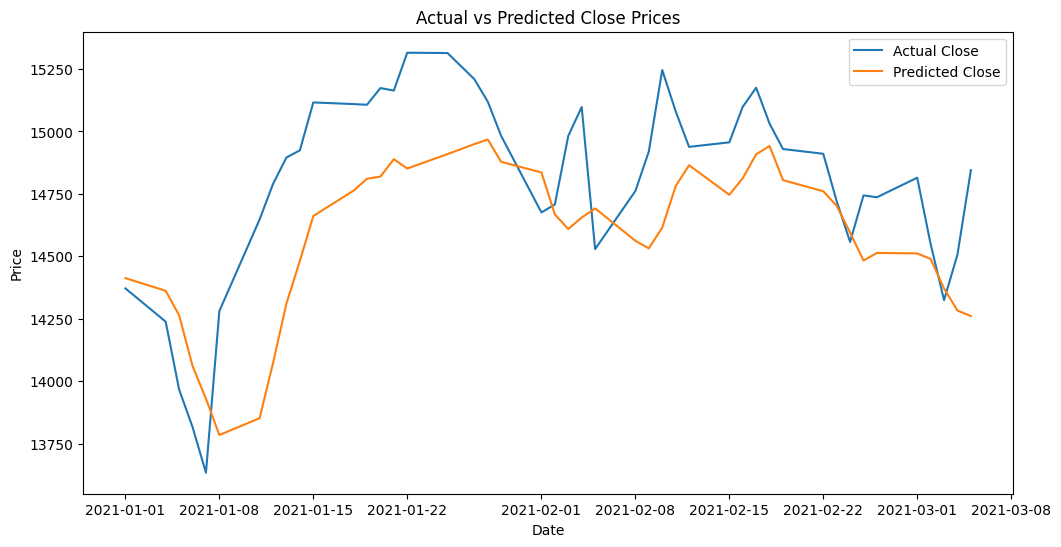

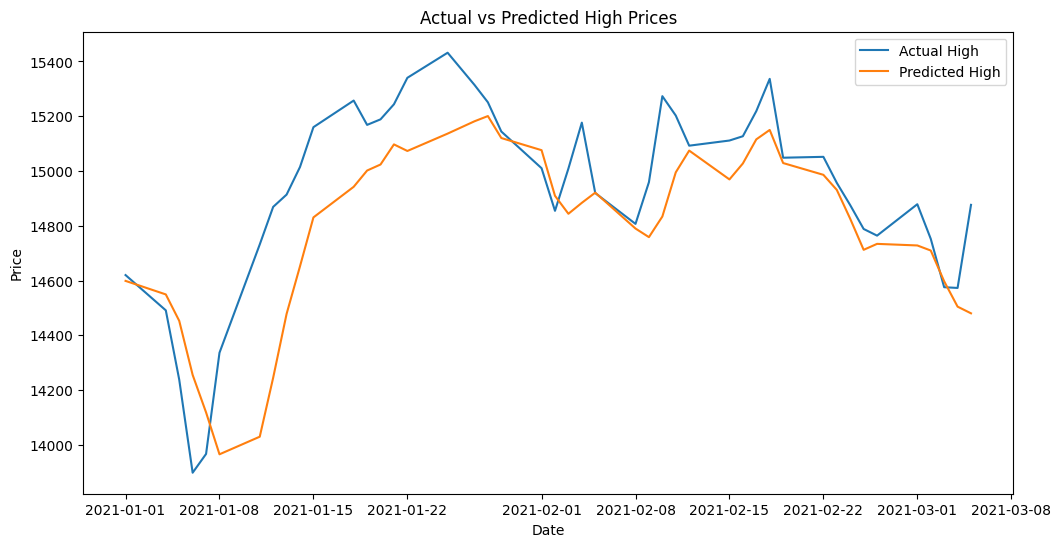

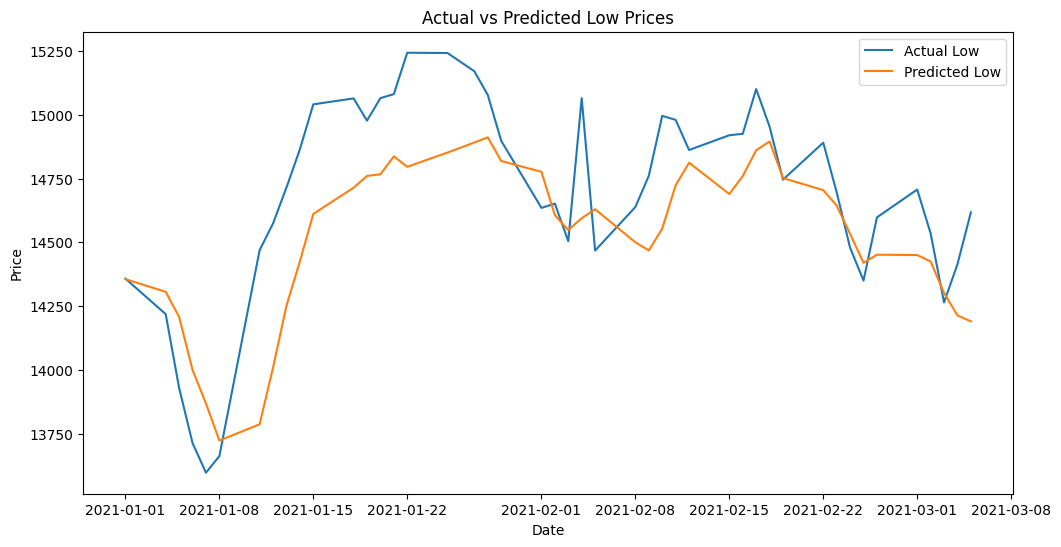

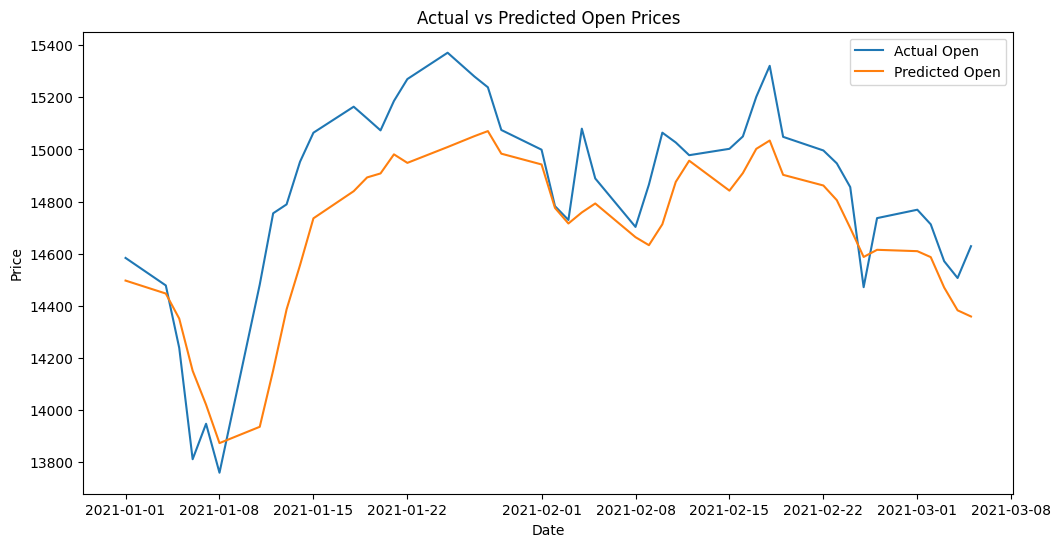

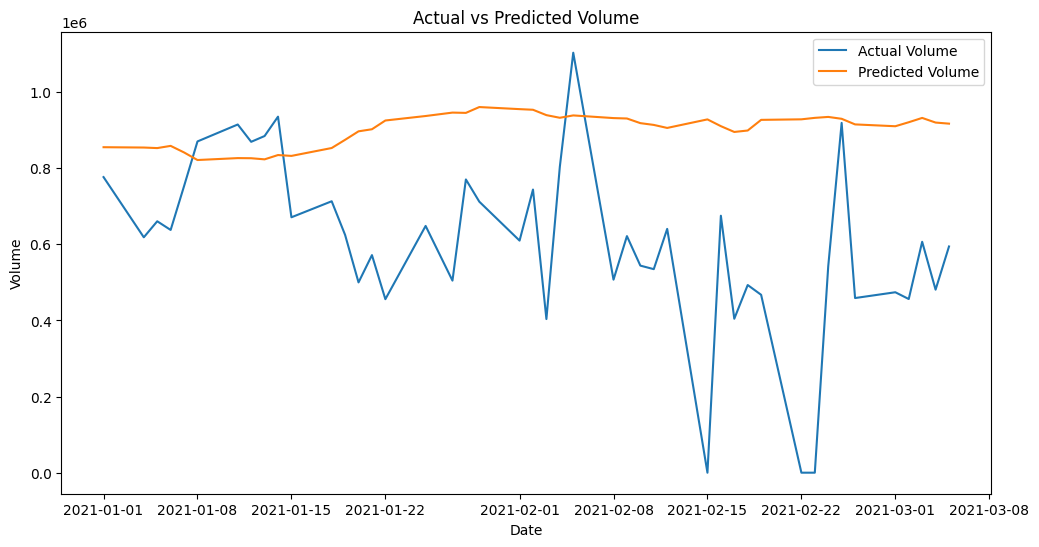

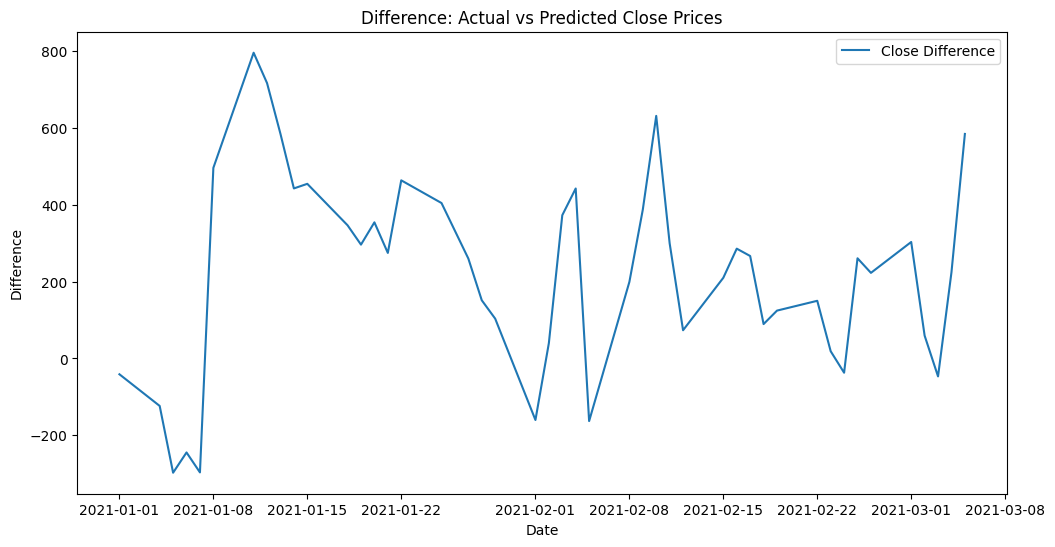

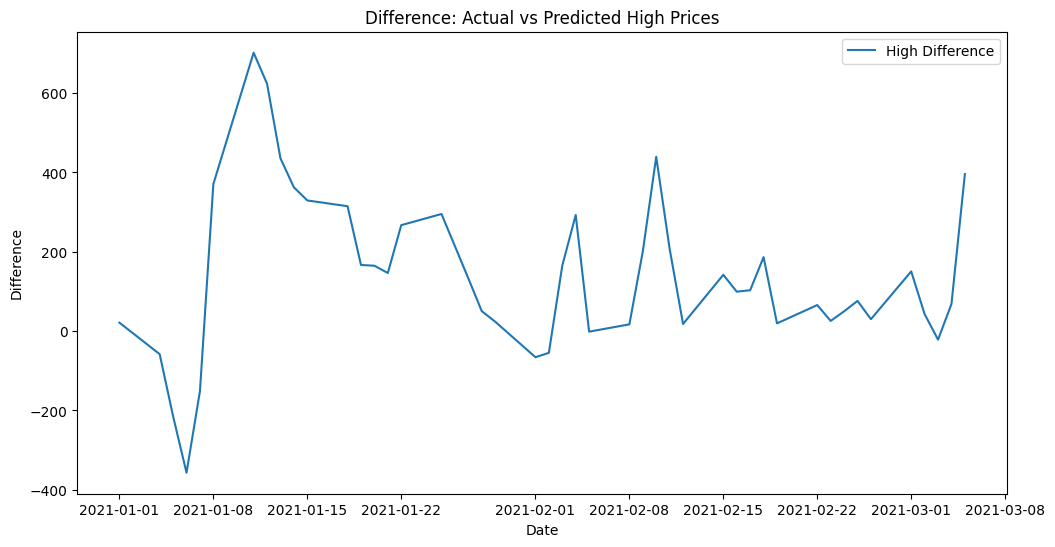

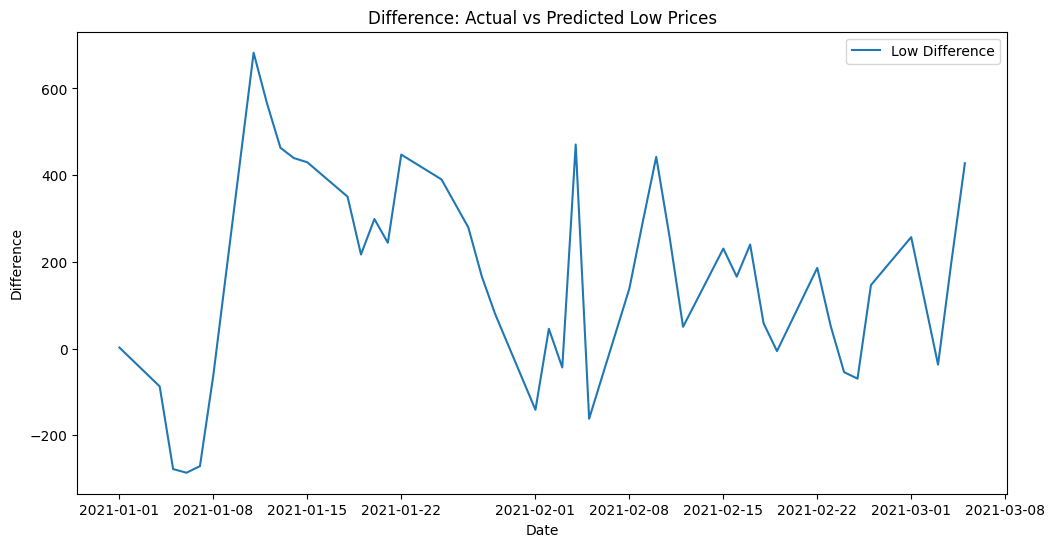

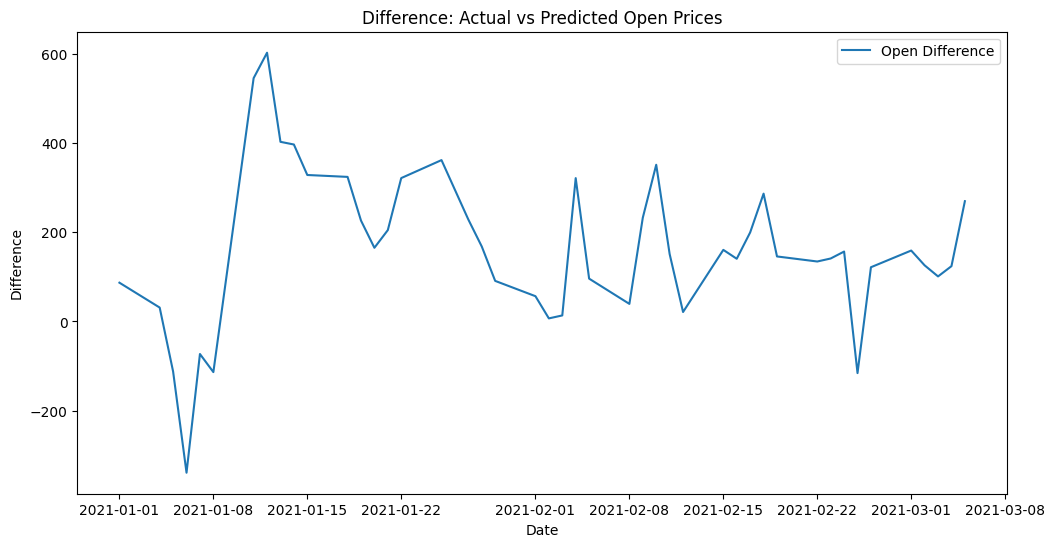

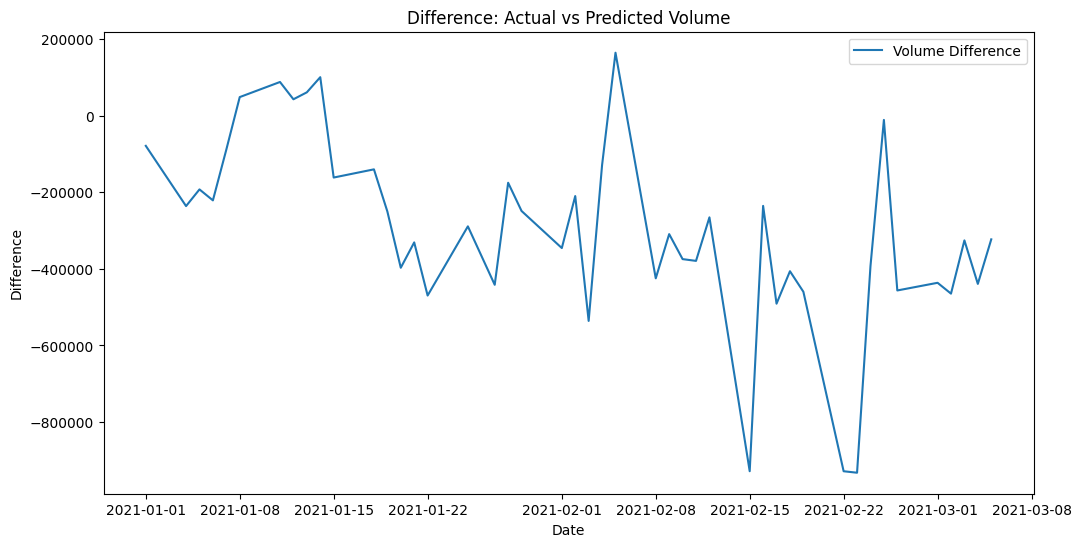

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = data
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return max(0, len(self.data) - self.seq_length)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.targets[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# LSTM Model with Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=30, num_layers=1, output_size=5, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Load and inspect CSV data
data = pd.read_csv("/kaggle/input/financial-data-2017-2021/merged_17_21.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Prepare features and targets
features = data[['sentiment']].values
targets = data[['High', 'Low', 'Close', 'Open', 'Volume']].values

# Normalize data
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

# Combine features and Close for sequence
data_scaled = np.hstack((features_scaled, targets_scaled[:, [2]]))  # Sentiment + Close

# Split data
train_data = data_scaled[data.index < '2021-01-01']
train_targets = targets_scaled[data.index < '2021-01-01']
test_data = data_scaled[data.index >= '2021-01-01']
test_targets = targets_scaled[data.index >= '2021-01-01']
test_dates = data.index[data.index >= '2021-01-01']  # Remove arbitrary -20 slicing

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# Create datasets
seq_length = 15
train_dataset = StockDataset(train_data, train_targets, seq_length)
test_dataset = StockDataset(test_data, test_targets, seq_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

if len(test_dataset) == 0:
    raise ValueError("Test dataset too small. Reduce seq_length or increase data.")

# Initialize model
model = LSTMModel(input_size=2, hidden_size=30, num_layers=1, output_size=5, dropout_rate=0.2).to(device)

# Loss and optimizer with L2 regularization
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop with early stopping
def train_model(model, optimizer, loader, epochs=50, patience=10):
    best_loss = float('inf')
    patience_counter = 0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Train model
train_model(model, optimizer, train_loader)

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            predictions.append(out.cpu().numpy())
            actuals.append(y.cpu().numpy())
    if not predictions:
        return np.array([]), np.array([])
    return np.concatenate(predictions), np.concatenate(actuals)

pred, act = evaluate_model(model, test_loader)

if pred.size == 0:
    raise ValueError("No predictions generated.")

# Inverse transform
pred_inv = scaler_targets.inverse_transform(pred)
act_inv = scaler_targets.inverse_transform(act)

# Extract values
pred_high, pred_low, pred_close, pred_open, pred_volume = pred_inv.T
act_high, act_low, act_close, act_open, act_volume = act_inv.T

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_close)], act_close, label='Actual Close')
plt.plot(test_dates[:len(pred_close)], pred_close, label='Predicted Close')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_high)], act_high, label='Actual High')
plt.plot(test_dates[:len(pred_high)], pred_high, label='Predicted High')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_low)], act_low, label='Actual Low')
plt.plot(test_dates[:len(pred_low)], pred_low, label='Predicted Low')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_open)], act_open, label='Actual Open')
plt.plot(test_dates[:len(pred_open)], pred_open, label='Predicted Open')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_volume)], act_volume, label='Actual Volume')
plt.plot(test_dates[:len(pred_volume)], pred_volume, label='Predicted Volume')
plt.title('Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Plot differences
diff_close = act_close - pred_close
diff_high = act_high - pred_high
diff_low = act_low - pred_low
diff_open = act_open - pred_open
diff_volume = act_volume - pred_volume

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(diff_close)], diff_close, label='Close Difference')
plt.title('Difference: Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(diff_high)], diff_high, label='High Difference')
plt.title('Difference: Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(diff_low)], diff_low, label='Low Difference')
plt.title('Difference: Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(diff_open)], diff_open, label='Open Difference')
plt.title('Difference: Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(diff_volume)], diff_volume, label='Volume Difference')
plt.title('Difference: Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

lstm+ccm

Train data size: 977
Test data size: 60
Training LSTM Model...
Epoch 1, Loss: 0.105719
Epoch 2, Loss: 0.021013
Epoch 3, Loss: 0.014180
Epoch 4, Loss: 0.009639
Epoch 5, Loss: 0.008585
Epoch 6, Loss: 0.008625
Epoch 7, Loss: 0.007942
Epoch 8, Loss: 0.007911
Epoch 9, Loss: 0.007481
Epoch 10, Loss: 0.007401
Epoch 11, Loss: 0.007240
Epoch 12, Loss: 0.006988
Epoch 13, Loss: 0.007006
Epoch 14, Loss: 0.006952
Epoch 15, Loss: 0.006270
Epoch 16, Loss: 0.006473
Epoch 17, Loss: 0.006135
Epoch 18, Loss: 0.006219
Epoch 19, Loss: 0.006092
Epoch 20, Loss: 0.005860
Epoch 21, Loss: 0.005916
Epoch 22, Loss: 0.005495
Epoch 23, Loss: 0.005484
Epoch 24, Loss: 0.005817
Epoch 25, Loss: 0.005446
Epoch 26, Loss: 0.005576
Epoch 27, Loss: 0.005454
Epoch 28, Loss: 0.005315
Epoch 29, Loss: 0.005301
Epoch 30, Loss: 0.005388
Epoch 31, Loss: 0.005271
Epoch 32, Loss: 0.005255
Epoch 33, Loss: 0.004948
Epoch 34, Loss: 0.004910
Epoch 35, Loss: 0.004850
Epoch 36, Loss: 0.004635
Epoch 37, Loss: 0.004667
Epoch 38, Loss: 0.004

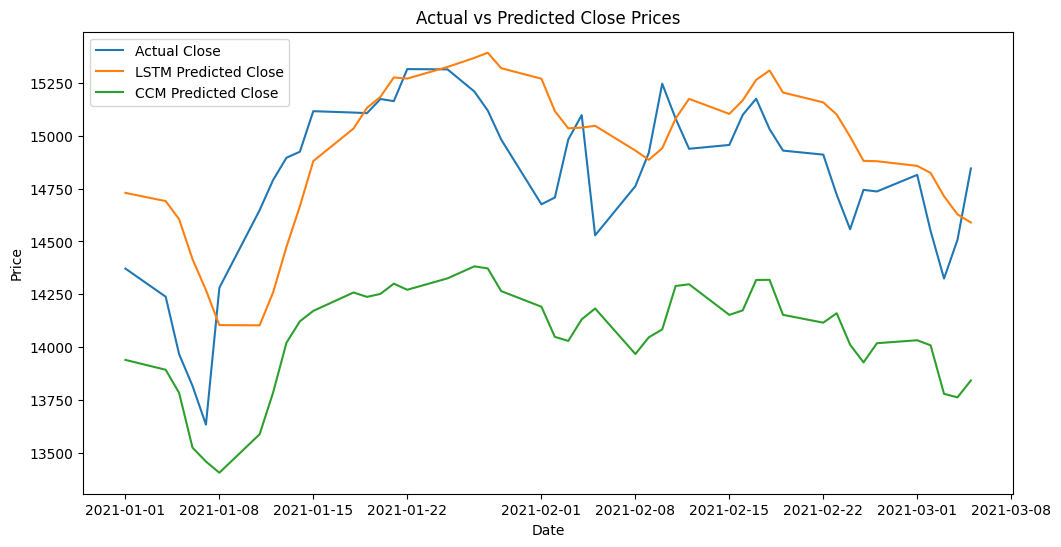

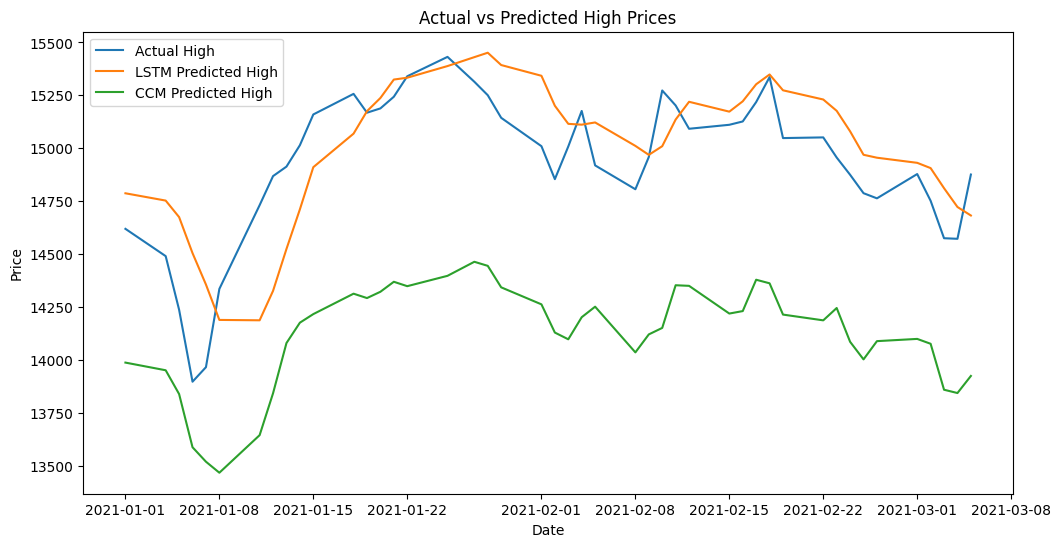

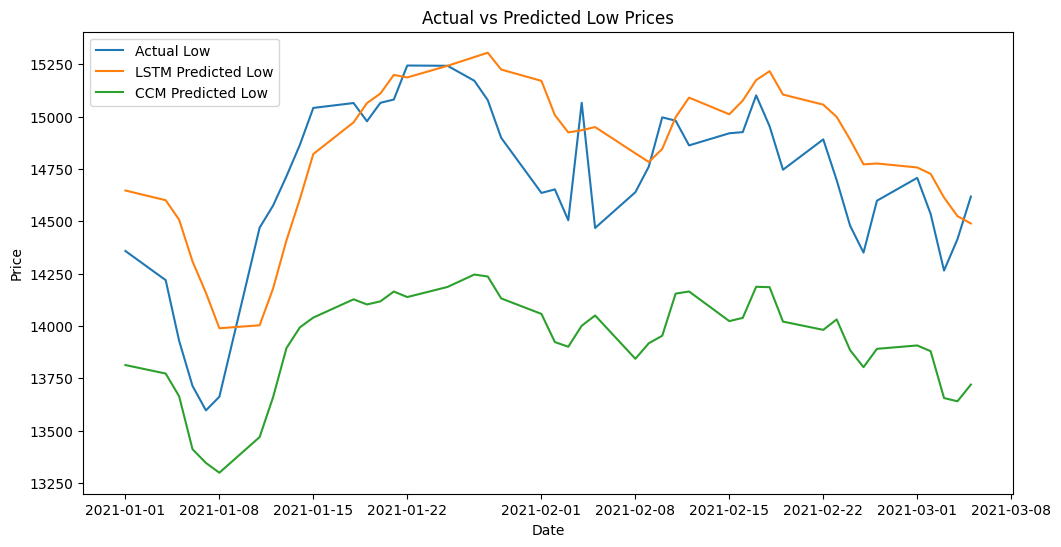

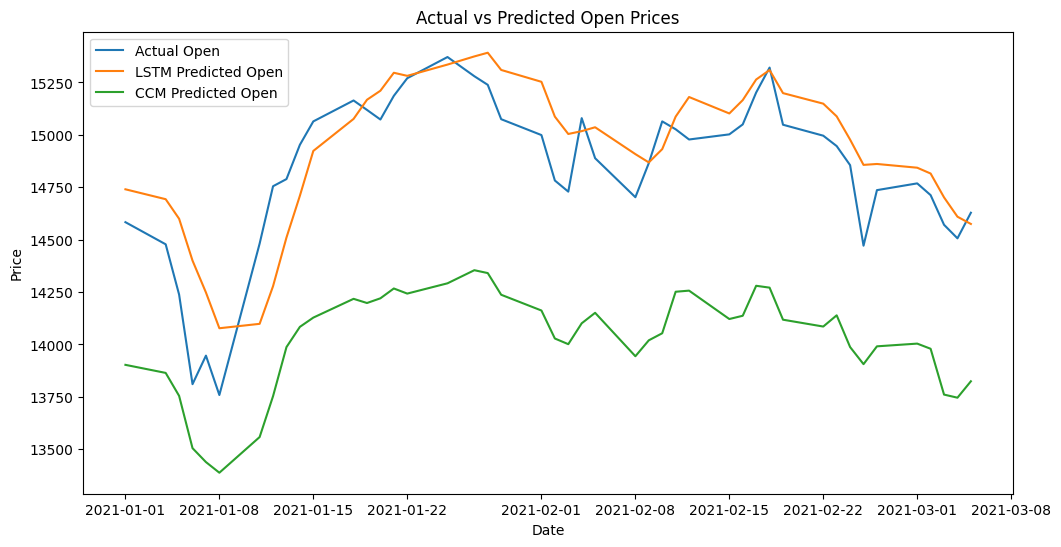

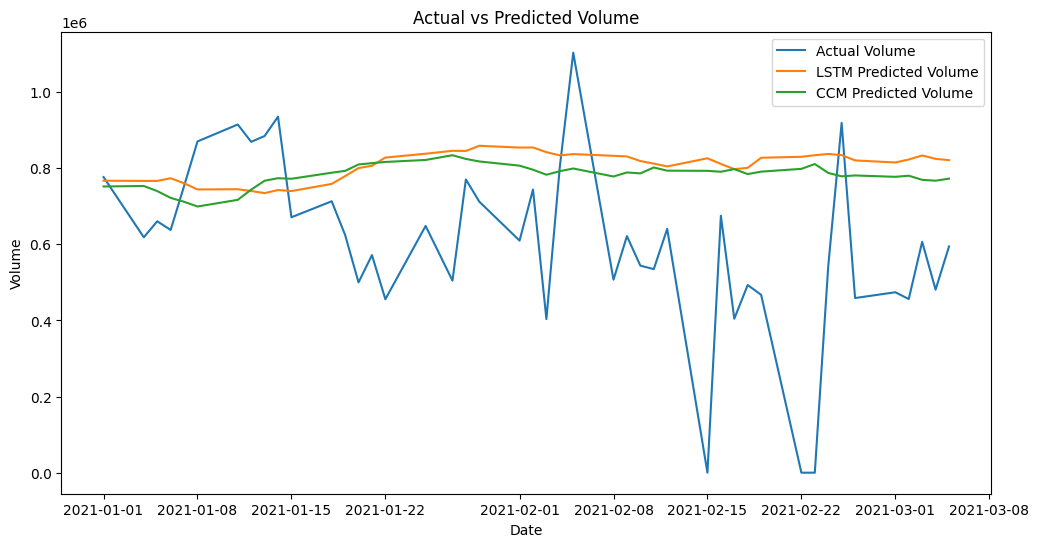

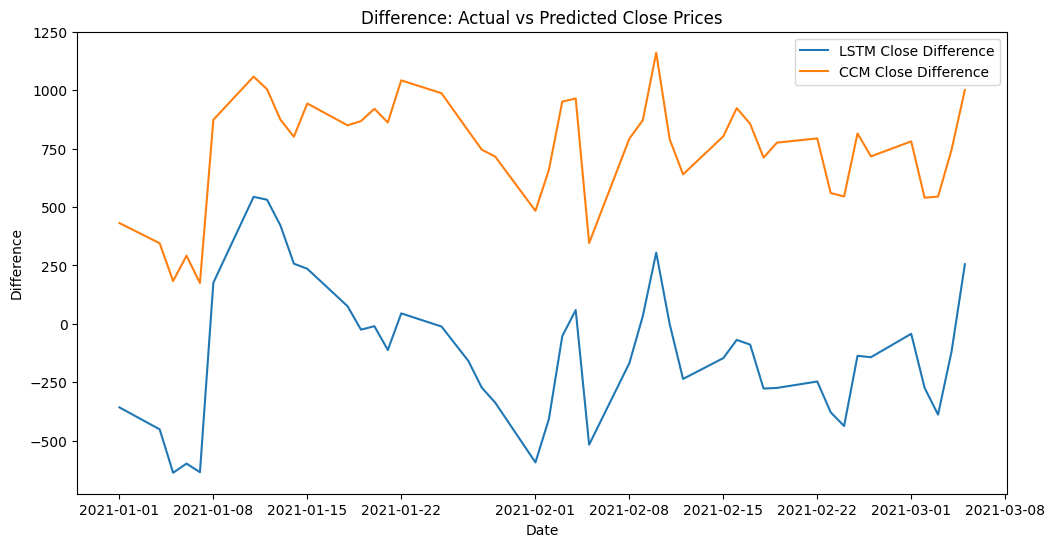

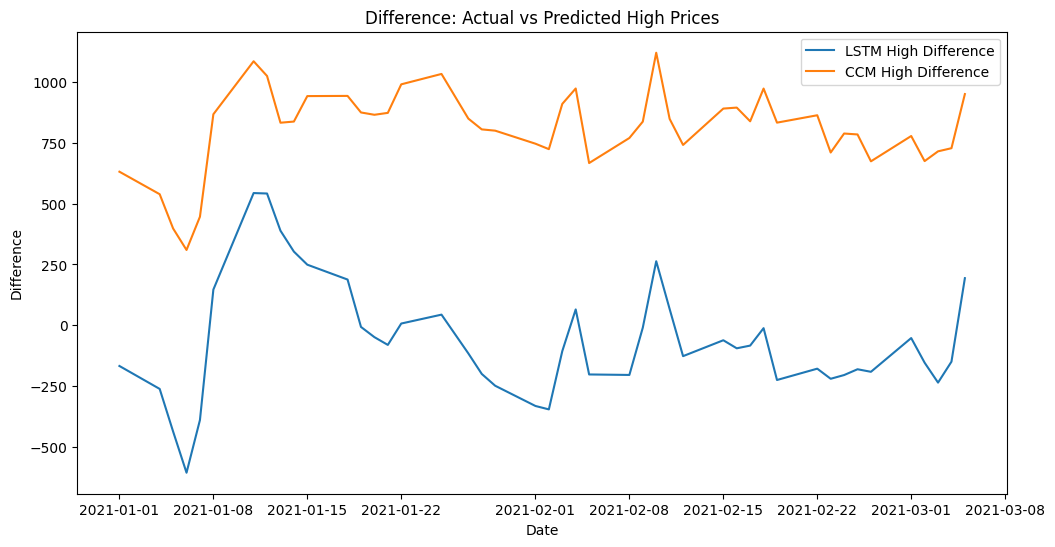

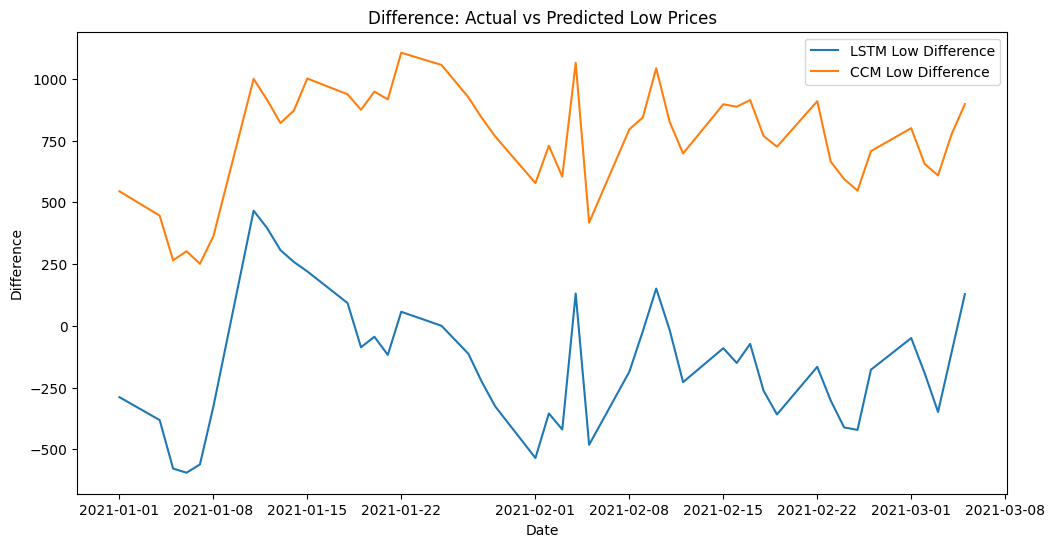

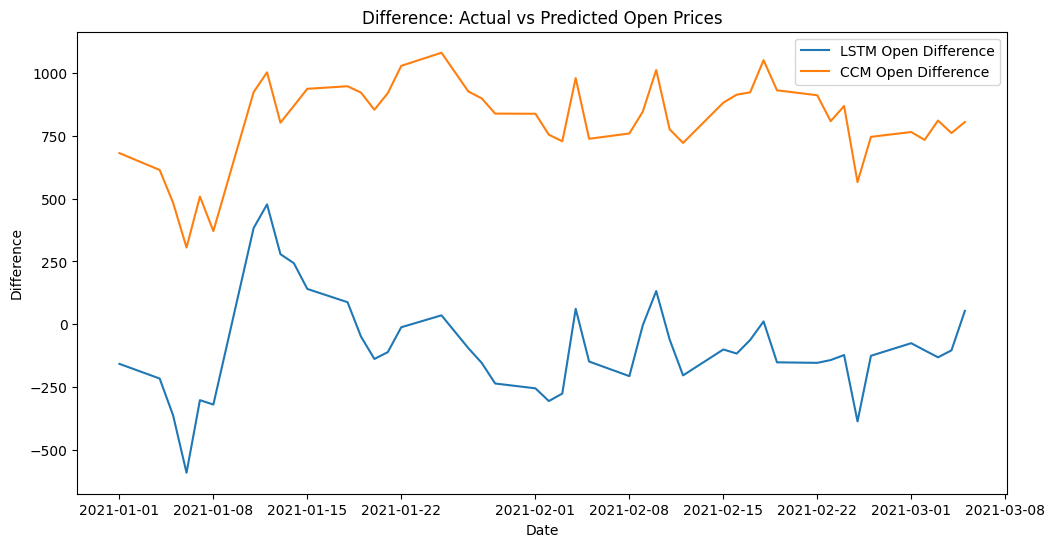

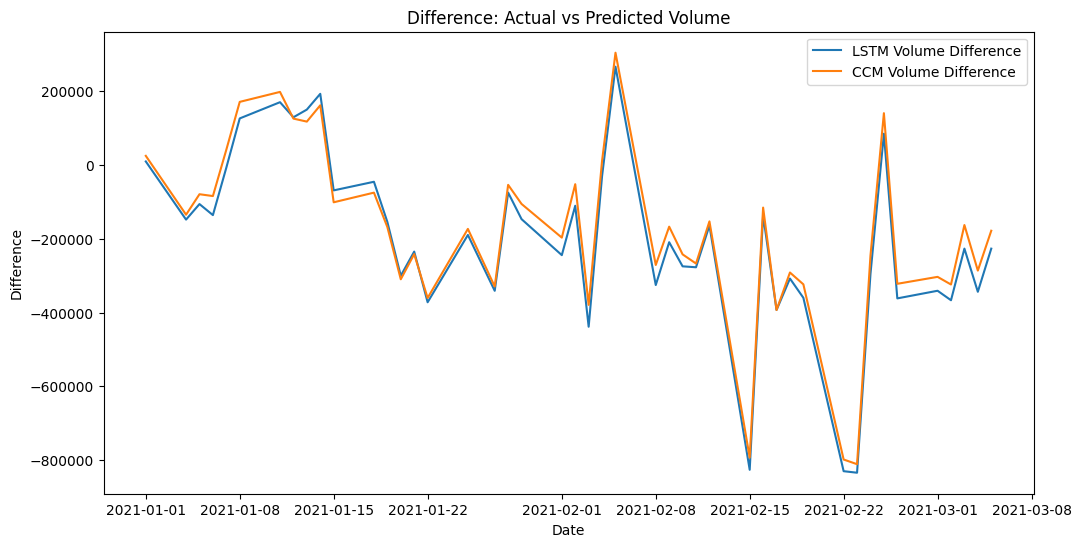

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = data
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return max(0, len(self.data) - self.seq_length)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.targets[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# LSTM Model with Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=30, num_layers=1, output_size=5, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# CCM Model
class CCMModel(nn.Module):
    def __init__(self, input_size=2, num_filters=32, kernel_size=3, output_size=5):
        super(CCMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # Adjust for Conv1d (batch, channels, seq_len)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.transpose(1, 2)  # Back to (batch, seq_len, features)
        x = self.dropout(x[:, -1, :])  # Take the last time step
        x = self.fc(x)
        return x

# Load and inspect CSV data
data = pd.read_csv("/kaggle/input/financial-data-2017-2021/merged_17_21.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Prepare features and targets
features = data[['sentiment']].values
targets = data[['High', 'Low', 'Close', 'Open', 'Volume']].values

# Normalize data
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

# Combine features and Close for sequence
data_scaled = np.hstack((features_scaled, targets_scaled[:, [2]]))  # Sentiment + Close

# Split data
train_data = data_scaled[data.index < '2021-01-01']
train_targets = targets_scaled[data.index < '2021-01-01']
test_data = data_scaled[data.index >= '2021-01-01']
test_targets = targets_scaled[data.index >= '2021-01-01']
test_dates = data.index[data.index >= '2021-01-01']

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# Create datasets
seq_length = 15
train_dataset = StockDataset(train_data, train_targets, seq_length)
test_dataset = StockDataset(test_data, test_targets, seq_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

if len(test_dataset) == 0:
    raise ValueError("Test dataset too small. Reduce seq_length or increase data.")

# Initialize models
lstm_model = LSTMModel(input_size=2, hidden_size=30, num_layers=1, output_size=5, dropout_rate=0.2).to(device)
ccm_model = CCMModel(input_size=2, num_filters=32, kernel_size=3, output_size=5).to(device)

# Loss and optimizer with L2 regularization
criterion = nn.MSELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-5)
ccm_optimizer = torch.optim.Adam(ccm_model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop with early stopping
def train_model(model, optimizer, loader, epochs=50, patience=10):
    best_loss = float('inf')
    patience_counter = 0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Train models
print("Training LSTM Model...")
train_model(lstm_model, lstm_optimizer, train_loader)
print("Training CCM Model...")
train_model(ccm_model, ccm_optimizer, train_loader)

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            predictions.append(out.cpu().numpy())
            actuals.append(y.cpu().numpy())
    if not predictions:
        return np.array([]), np.array([])
    return np.concatenate(predictions), np.concatenate(actuals)

# Evaluate both models
lstm_pred, act = evaluate_model(lstm_model, test_loader)
ccm_pred, act = evaluate_model(ccm_model, test_loader)

if lstm_pred.size == 0 or ccm_pred.size == 0:
    raise ValueError("No predictions generated.")

# Inverse transform
lstm_pred_inv = scaler_targets.inverse_transform(lstm_pred)
ccm_pred_inv = scaler_targets.inverse_transform(ccm_pred)
act_inv = scaler_targets.inverse_transform(act)

# Extract values
lstm_pred_high, lstm_pred_low, lstm_pred_close, lstm_pred_open, lstm_pred_volume = lstm_pred_inv.T
ccm_pred_high, ccm_pred_low, ccm_pred_close, ccm_pred_open, ccm_pred_volume = ccm_pred_inv.T
act_high, act_low, act_close, act_open, act_volume = act_inv.T

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_close)], act_close, label='Actual Close')
plt.plot(test_dates[:len(lstm_pred_close)], lstm_pred_close, label='LSTM Predicted Close')
plt.plot(test_dates[:len(ccm_pred_close)], ccm_pred_close, label='CCM Predicted Close')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_high)], act_high, label='Actual High')
plt.plot(test_dates[:len(lstm_pred_high)], lstm_pred_high, label='LSTM Predicted High')
plt.plot(test_dates[:len(ccm_pred_high)], ccm_pred_high, label='CCM Predicted High')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_low)], act_low, label='Actual Low')
plt.plot(test_dates[:len(lstm_pred_low)], lstm_pred_low, label='LSTM Predicted Low')
plt.plot(test_dates[:len(ccm_pred_low)], ccm_pred_low, label='CCM Predicted Low')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_open)], act_open, label='Actual Open')
plt.plot(test_dates[:len(lstm_pred_open)], lstm_pred_open, label='LSTM Predicted Open')
plt.plot(test_dates[:len(ccm_pred_open)], ccm_pred_open, label='CCM Predicted Open')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(act_volume)], act_volume, label='Actual Volume')
plt.plot(test_dates[:len(lstm_pred_volume)], lstm_pred_volume, label='LSTM Predicted Volume')
plt.plot(test_dates[:len(ccm_pred_volume)], ccm_pred_volume, label='CCM Predicted Volume')
plt.title('Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Plot differences
lstm_diff_close = act_close - lstm_pred_close
ccm_diff_close = act_close - ccm_pred_close
lstm_diff_high = act_high - lstm_pred_high
ccm_diff_high = act_high - ccm_pred_high
lstm_diff_low = act_low - lstm_pred_low
ccm_diff_low = act_low - ccm_pred_low
lstm_diff_open = act_open - lstm_pred_open
ccm_diff_open = act_open - ccm_pred_open
lstm_diff_volume = act_volume - lstm_pred_volume
ccm_diff_volume = act_volume - ccm_pred_volume

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(lstm_diff_close)], lstm_diff_close, label='LSTM Close Difference')
plt.plot(test_dates[:len(ccm_diff_close)], ccm_diff_close, label='CCM Close Difference')
plt.title('Difference: Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(lstm_diff_high)], lstm_diff_high, label='LSTM High Difference')
plt.plot(test_dates[:len(ccm_diff_high)], ccm_diff_high, label='CCM High Difference')
plt.title('Difference: Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(lstm_diff_low)], lstm_diff_low, label='LSTM Low Difference')
plt.plot(test_dates[:len(ccm_diff_low)], ccm_diff_low, label='CCM Low Difference')
plt.title('Difference: Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(lstm_diff_open)], lstm_diff_open, label='LSTM Open Difference')
plt.plot(test_dates[:len(ccm_diff_open)], ccm_diff_open, label='CCM Open Difference')
plt.title('Difference: Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(lstm_diff_volume)], lstm_diff_volume, label='LSTM Volume Difference')
plt.plot(test_dates[:len(ccm_diff_volume)], ccm_diff_volume, label='CCM Volume Difference')
plt.title('Difference: Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()